In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'
import os
import sys
sys.path.insert(0, os.path.abspath('../src/'))

This notebook is a tutorial jupyter notebook of the package ``structure_factor`` version 2.0.1 designed to study the structure factor of a point process and test its hyperuniformity. 
We use the Ginibre point process as a running example. It is convenient, since its pair correlation function, structure factor, and hyperuniformity class are analytically known.
It's a plug-and-play notebook, you can simply change the point process used, by modifying the ``PointPattern``, then run the notebook on your point process.

# 1- Installation

If the package is not already installed/updated on your local machine you can simply use the following first-line/second for the installation/update.

In [2]:
# !pip install structure-factor
# !pip install structure-factor --upgrade

# 2- Creat a PointPattern object 

To create an object of type ``PointPattern`` from a point process, we need a sample of points generated from the point process, the observation window which must be ``BallWindow`` or  ``BoxWindow``, and the intensity of the point process (optional). 
A ``PointPattern`` from the Poisson, Thomas, Ginibre, or KLY point process could be created using the module ``point_process`` of this package. 
For more details, we refer to the documentation of this project https://for-a-few-dpps-more.github.io/structure-factor/
In what follows we will be loading a Ginibre PointPattern (instead of creating one) using ``load_data`` from the module ``data``.

<AxesSubplot:>

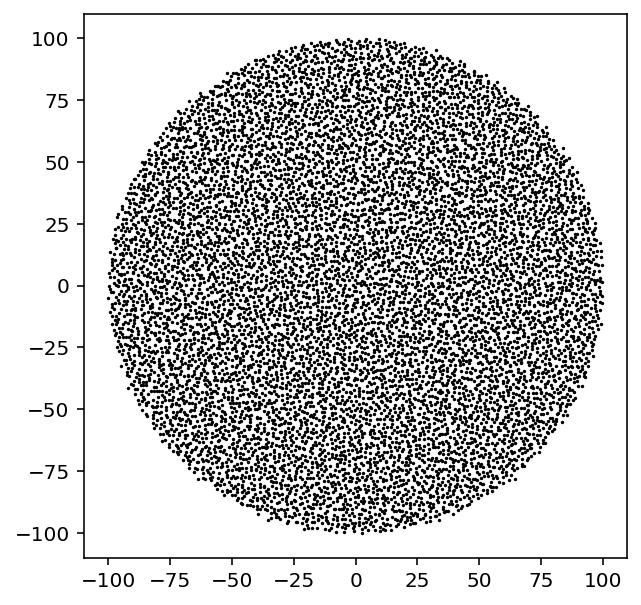

In [3]:
# Load Ginibre PointPattern 
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.data import load_data

# Load
point_pattern_ball = load_data.load_ginibre()
# Plot
point_pattern_ball.plot()

In [4]:
# Or creat a Ginibre PointPattern as follows

#from structure_factor.point_pattern import PointPattern
#from structure_factor.point_processes import GinibrePointProcess
#from structure_factor.spatial_windows import BallWindow

#point_process = GinibrePointProcess()

#window = BallWindow(center=[0, 0], radius=20)
#points = point_process.generate_sample(window=window)
#point_pattern_ball = PointPattern(points=points, window=window, intensity=point_process.intensity)

The exact structure factor and the pair correlation function of the Ginibre point process are known so we will use them to compare with the estimated values.

In [5]:
from structure_factor.point_processes import GinibrePointProcess

point_process = GinibrePointProcess()
exact_sf = point_process.structure_factor
exact_pcf = point_process.pair_correlation_function

# 3- Approximate the structure factor

Actually, the package gathers estimators of the structure factor for:

        1- stationary point processes, 
        2- stationary and isotropic point processes.

## 3.1- Estimators assuming stationarity

The estimators that assume the stationarity of the point process, apply to ``PointPattern`` having ``BoxWindow``.
As ``point_pattern_ball`` has a ``BallWindow`` we will first restrict it to a new ``PointPattern`` with ``BoxWindow``.

<AxesSubplot:>

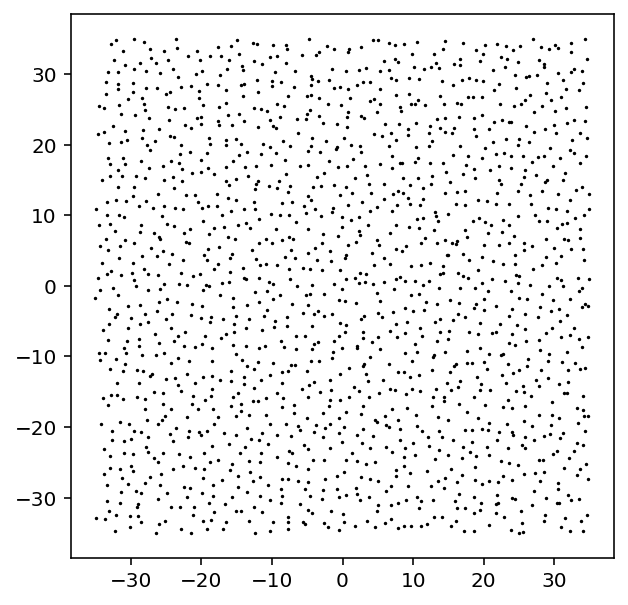

In [6]:
# Restrict to a BoxWindow
from structure_factor.spatial_windows import BoxWindow

l = 70 # length side of the BoxWindow
box_window = BoxWindow(bounds=[[-l/2, l/2], [-l/2, l/2]]) # BoxWindow
point_pattern_box = point_pattern_ball.restrict_to_window(box_window) # Restrict to box_window
# Plot
point_pattern_box.plot()


As we have the adequate ``PointPattern`` we will initialize StructureFactor and then use the estimators progressively.

In [7]:
from structure_factor.structure_factor import StructureFactor

sf = StructureFactor(point_pattern_box) 

### 3.1.1- Scattering intensity

The scattering intensity $\widehat{S}_{\mathrm{SI}}$ is an estimator of the structure factor $S$ of a stationary point process.
It could be evaluated on arbitrary wavevectors, or allowed wavevectors (reduce bias).
It has also 2 debiased versions directly/undirectly.
It is a particular case of the tapered estimator $\widehat{S}_{\mathrm{T}}$ with Bartlett's taper.

<AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(\\mathbf{k})$)'>

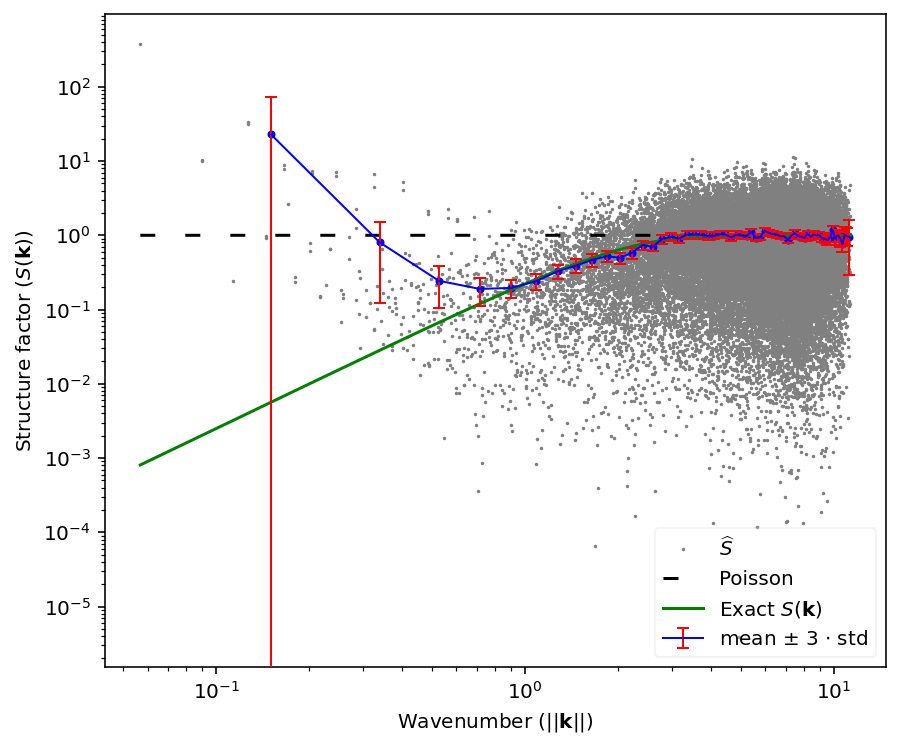

In [8]:
# Scattering intensity on arbitrary wavevectors
import numpy as np

# Construct a grid of wavevectors
k_max=8 # Threshold on the maximum wavenumber
x = np.linspace(0, k_max, 200)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k = np.column_stack((X.ravel(), Y.ravel())) # Wavevectors

# Scattering intensity on k 
k, s_si_k = sf.scattering_intensity(k=k, debiased=False )

# Plot
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize=(7,6))
sf.plot_non_isotropic_estimator(k, s_si_k, 
                                axes=axis, # Plot axis
                                plot_type="radial", # Plot type (radial, all or imshow)
                                exact_sf=exact_sf, # Exact structure factor 
                                error_bar=True, bins=60, # Regularization of the result
                                scale="log", # Scale
                                rasterized=True, # Rasterized the approximation points
                                label=r"$\widehat{S}$", # Label
                                # file_name="s_si.pdf" # Save the figure
                                      )

The asymptotic bias of $\widehat{S}_{\mathrm{SI}}$ at small non allowed wavenumber $k$ is visible.
To deal with this bias we can use one of the following three debiased versions.

/Users/dhawat/github/structure-factor/src/structure_factor/tapered_estimators.py:94: UserWarning: The computation on all allowed wavevectors may be time-consuming.
  warnings.warn(


array([<AxesSubplot:>,
       <AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(\\mathbf{k})$)'>,
       <AxesSubplot:>], dtype=object)

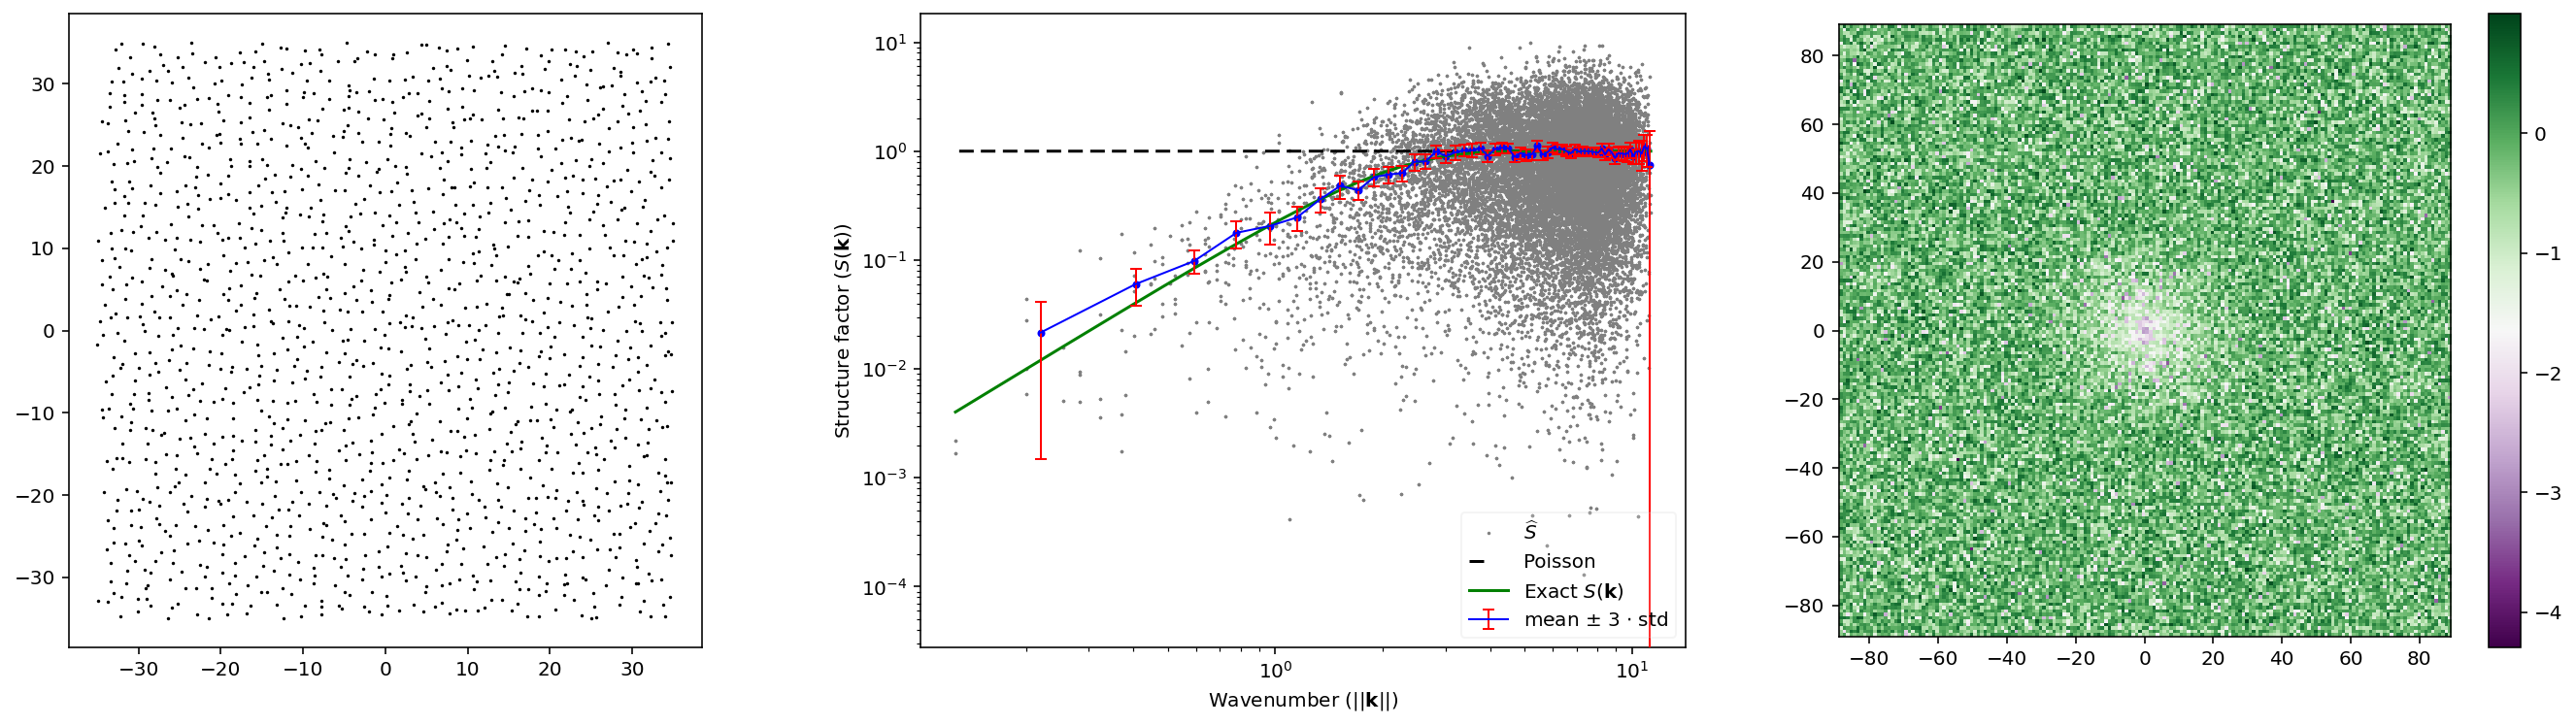

In [9]:
# Scattering intensity on allowed wavevectors

k_max=8 # Threshold on the maximum wavenumber 
allowed_k, s_si_allowed_k = sf.scattering_intensity(k_max=k_max)

# Plot
sf.plot_non_isotropic_estimator(allowed_k, s_si_allowed_k, 
                                       plot_type="all", # Plot type  
                                       exact_sf=exact_sf, # Exact structure factor 
                                       error_bar=True, bins=60, # Regularization of the result
                                       label=r"$\widehat{S}$",
                                      # file_name="ginibre_s_si.pdf" # Save the figure
                                      )

array([<AxesSubplot:>,
       <AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(\\mathbf{k})$)'>,
       <AxesSubplot:>], dtype=object)

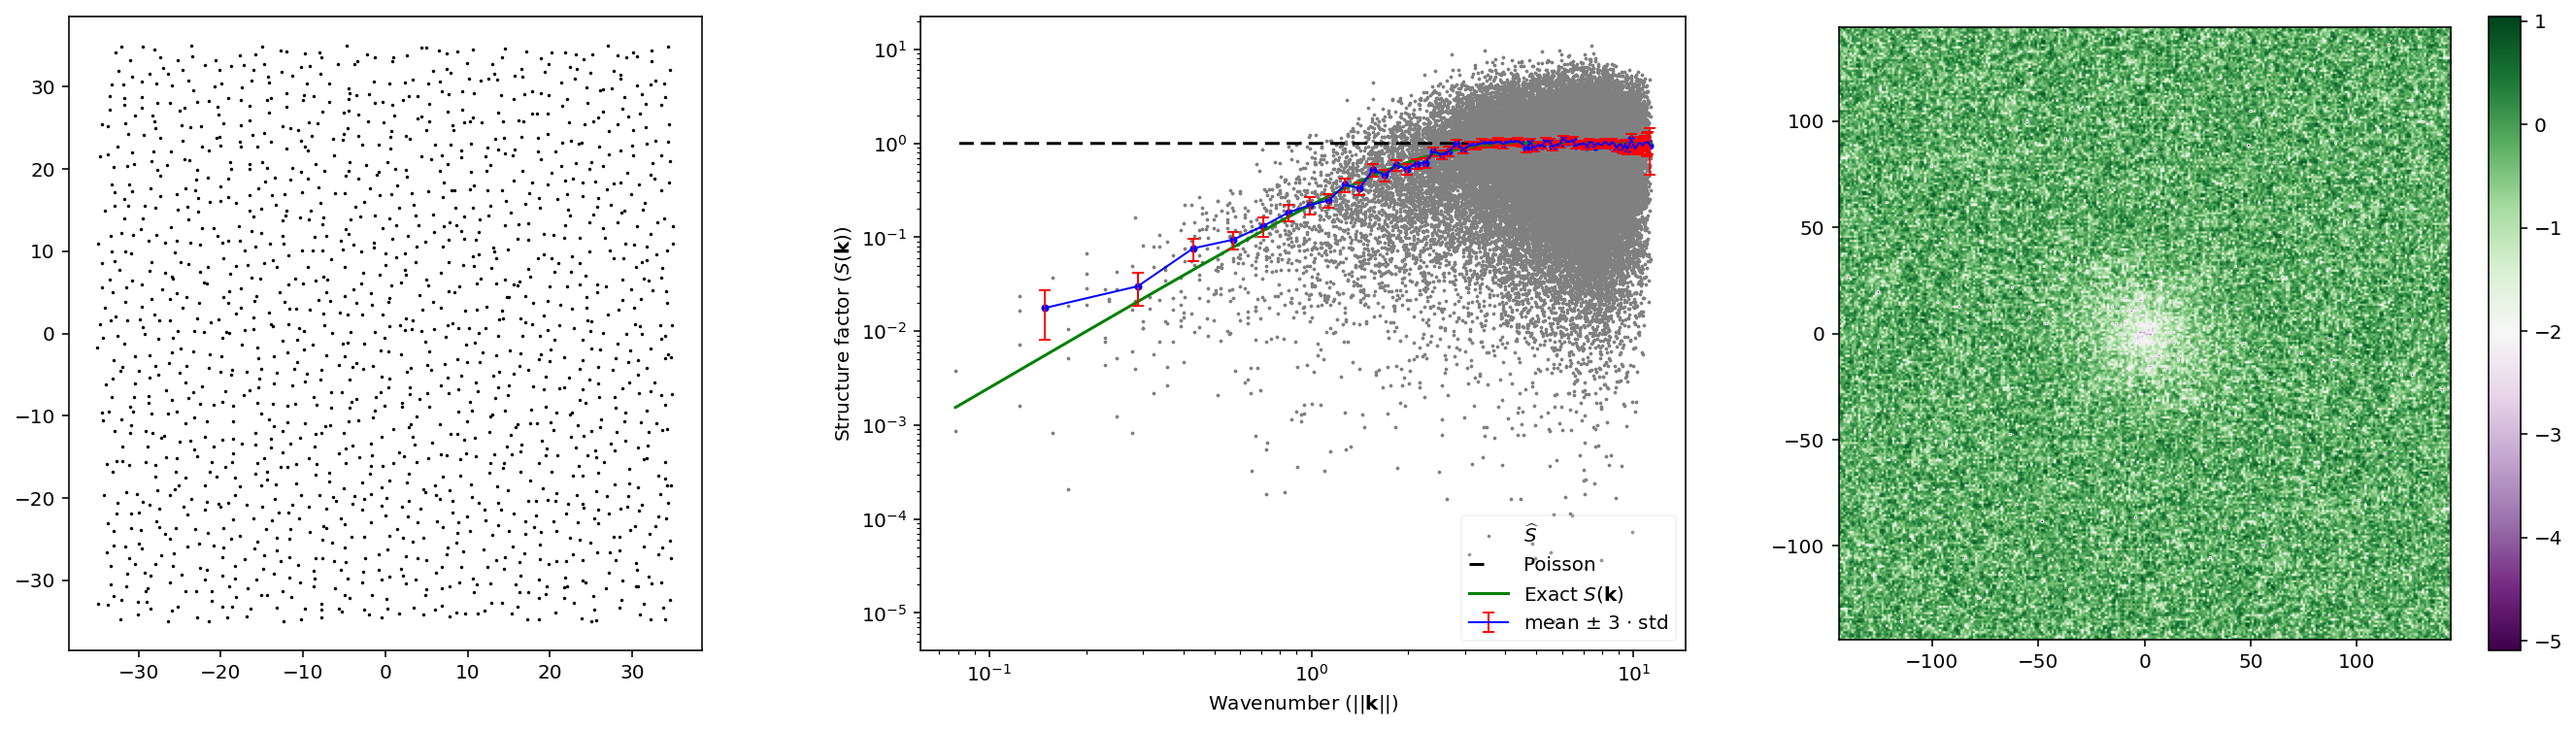

In [10]:
# Scattering intensity directly debiased on arbitrary wavevectors

# Construct grid of wavevectors
k_max=8 # Threshold on the maximum wavenumber
x = np.linspace(-k_max, k_max, 17**2)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k = np.column_stack((X.ravel(), Y.ravel())) # Wavevectors
# Scattering intensity on k 
k, s_si_dd = sf.scattering_intensity(k=k, debiased=True,  direct=True)

# Plot
import matplotlib.pyplot as plt

sf.plot_non_isotropic_estimator(k, s_si_dd,  
                                       plot_type="all", # Plot type
                                       exact_sf=exact_sf, # Exact structure factor 
                                       error_bar=True, bins=80, # Regularization of the result
                                       scale="log", # Scale
                                       rasterized=True, # Rasterized the approximation points
                                       label=r"$\widehat{S}$")

<AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(\\mathbf{k})$)'>

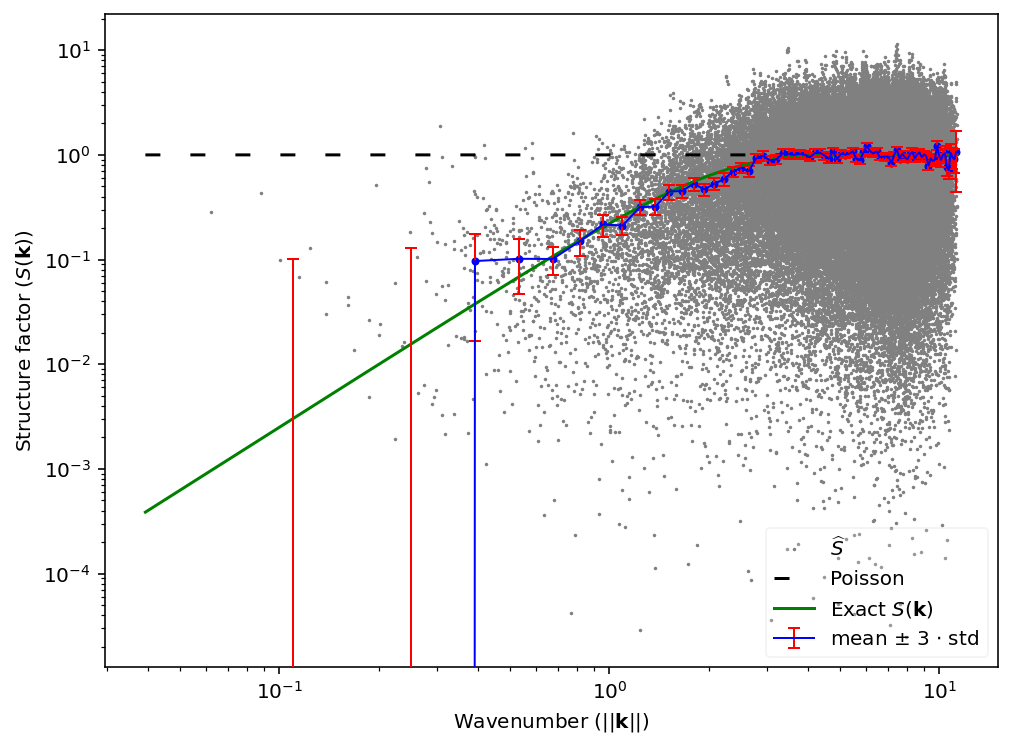

In [11]:
# Scattering intensity undirectly debiased on arbitrary wavevectors

# Construct grid of wavevectors
k_max=8 # Threshold on the maximum wavenumber
x = np.linspace(0, k_max, 17**2)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k = np.column_stack((X.ravel(), Y.ravel())) # Wavevectors
# Scattering intensity on k 
k, s_si_ud = sf.scattering_intensity(k=k, debiased=True, direct=False)

# Plot
import matplotlib.pyplot as plt

sf.plot_non_isotropic_estimator(k, s_si_ud, 
                                #positive=True, # Plot only positive values
                                plot_type="radial", # Plot type
                                exact_sf=exact_sf, # Exact structure factor 
                                error_bar=True, bins=80, # Regularization of the result
                                scale="log", # Scale
                                rasterized=True, # Rasterized the approximation points
                                label=r"$\widehat{S}$")

The estimator returned a few negative values again, resulting in large inaccuracies in our log-log scale.
You can add ``positive=True`` to the plot function to consider only positive values.

### 3.1.2- Tapered estimator with a single sine taper

The tapered estimator $\widehat{S}_{\mathrm{T}}$ is an estimator of the structure factor $S$ of a stationary point process depending on a taper function.
It has 2 debiased versions $\widehat{S}_{\mathrm{DDT}}$, and $\widehat{S}_{\mathrm{UDT}}$ (directly/undirectly).
In what follows, we will be using the first taper of the family of sinusoidal tapers available in the module ``tapers``.
To use a new taper follow the example in the documentation.

<AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(\\mathbf{k})$)'>

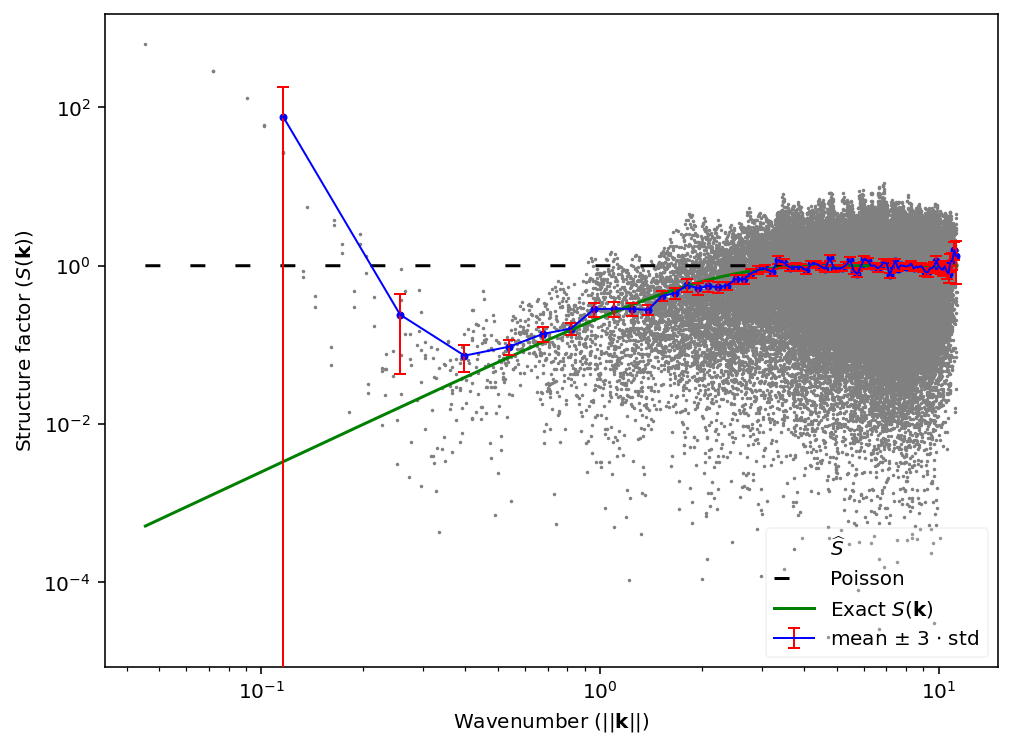

In [13]:
# Tapered estimator
from structure_factor.tapers import SineTaper
 
k_max = 8 # Threshold on the maximum wavenumber
x = np.linspace(0, k_max, 250)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k = np.column_stack((X.ravel(), Y.ravel()))

# First taper of the family of sinusoidal tapers
p = [1, 1]
tapers = [SineTaper(p)]

# Tapered estimator
k, s_t = sf.tapered_estimator(k, tapers=tapers, debiased=False)

# Plot
sf.plot_non_isotropic_estimator(k, s_t, 
                                plot_type="radial", # Plot type
                                exact_sf=exact_sf, # Exact structure factor 
                                error_bar=True, bins=80, # Regularization of the result
                                scale="log", # Scale
                                rasterized=True, # Rasterized the approximation points
                                label=r"$\widehat{S}$")

The asymptotic bias of $\widehat{S}_{\mathrm{T}}$ at small wavenumber $k$ is visible. To deal with this bias we can use one of the following two debiased versions.

<AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(\\mathbf{k})$)'>

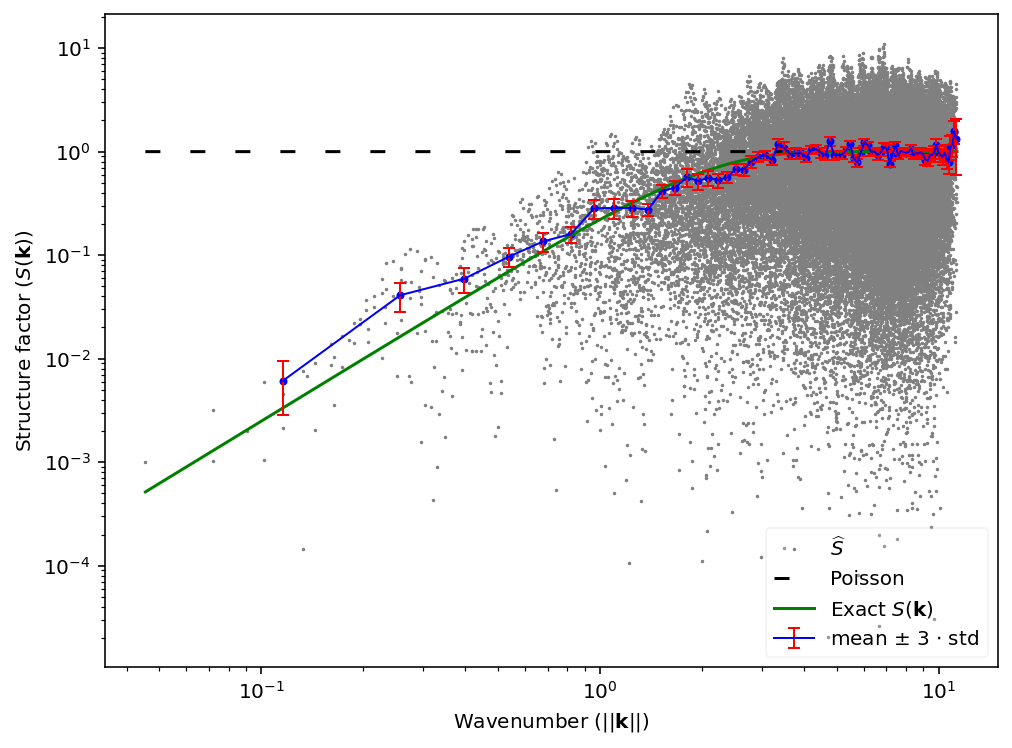

In [14]:
# Directly debiased tapered estimator

from structure_factor.tapers import SineTaper
 
k_max = 8 # Threshold on the maximum wavenumber
x = np.linspace(0, k_max, 250)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k = np.column_stack((X.ravel(), Y.ravel()))

# First taper of the family of sinusoidal tapers
p = [1, 1]
tapers = [SineTaper(p)]

# Tapered estimator
k, s_ddt = sf.tapered_estimator(k, tapers=tapers, debiased=True, direct=True)

# Plot
sf.plot_non_isotropic_estimator(k, s_ddt, 
                                plot_type="radial", # Plot type
                                exact_sf=exact_sf, # Exact structure factor 
                                error_bar=True, bins=80, # Regularization of the result
                                scale="log", # Scale
                                rasterized=True, # Rasterized the approximation points
                                label=r"$\widehat{S}$")

<AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(\\mathbf{k})$)'>

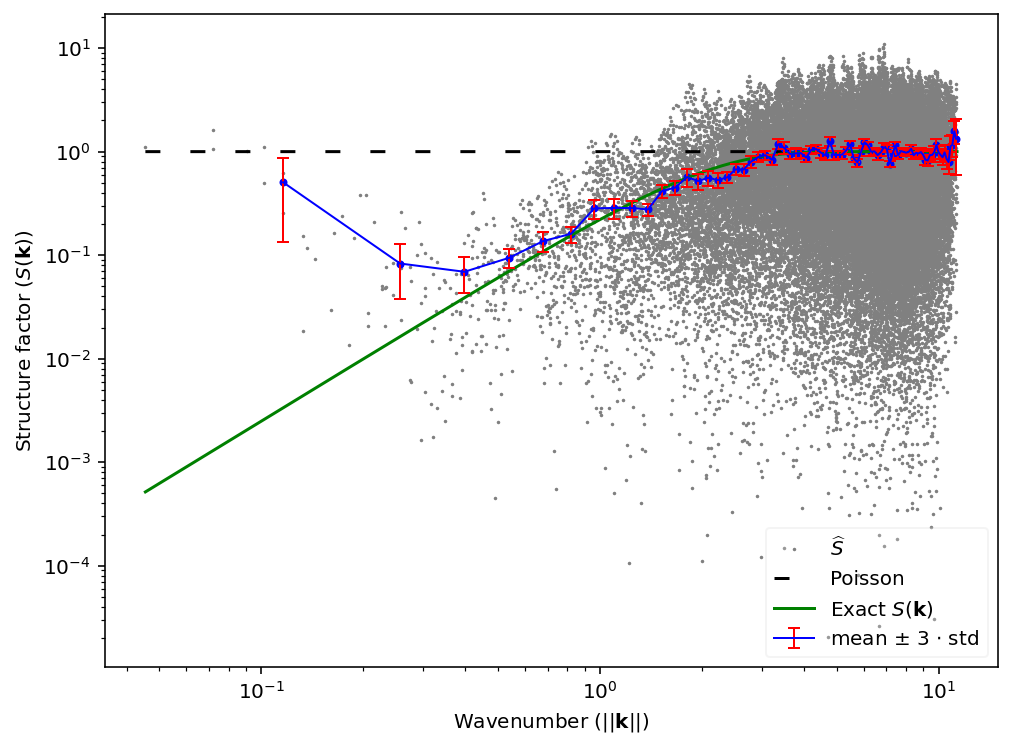

In [15]:
# Undirectly debiased tapered estimator
from structure_factor.tapers import SineTaper

# Wavevectors
k_max = 8 # Threshold on the maximum wavenumber
x = np.linspace(0, k_max, 250)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k = np.column_stack((X.ravel(), Y.ravel()))

# First taper of the family of sinusoidal tapers
p = [1, 1]
tapers = [SineTaper(p)]

# Tapered estimator
k, s_udt = sf.tapered_estimator(k, tapers=tapers, debiased=True, direct=False)

# Plot
sf.plot_non_isotropic_estimator(k, s_udt, 
                                positive=True, # Consider only positive values
                                plot_type="radial", # Plot type
                                exact_sf=exact_sf, # Exact structure factor 
                                error_bar=True, bins=80, # Regularization of the result
                                scale="log", # Scale
                                rasterized=True, # Rasterized the approximation points
                                label=r"$\widehat{S}$")

### 3.1.3- Multitapered estimator

The multitapered estimator $\widehat{S}_{\mathrm{MT}}$ is an estimator of the structure factor $S$ of a stationary point process depending on a family of tapers. 
It is a generalization of the tapered estimator $\widehat{S}_{\mathrm{T}}$.
It has 2 debiased versions $\widehat{S}_{\mathrm{DDMT}}$, and $\widehat{S}_{\mathrm{UDMT}}$ (directly/undirectly).
In what follows, we will be using the first 4 tapers of the family of sinusoidal tapers available in the module ``tapers``.
To use a new family of tapers, follow the example present in the documentation.

<AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(\\mathbf{k})$)'>

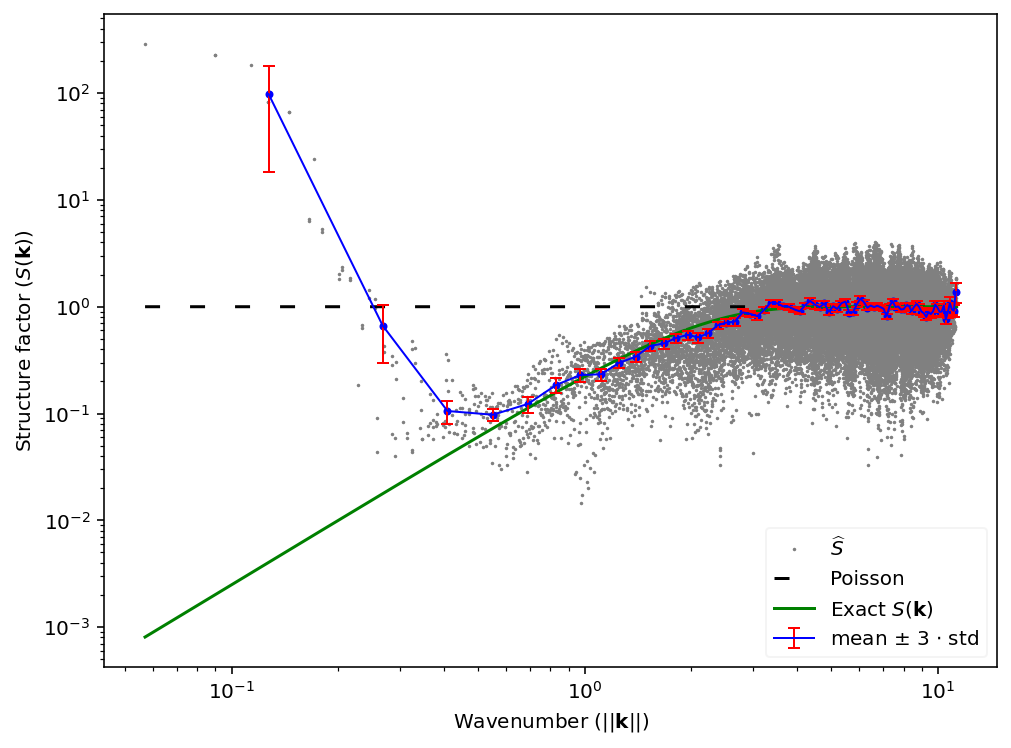

In [16]:
# Multitapered estimator
from structure_factor.tapers import SineTaper
 
# Wavevectors
k_max = 8 # Threshold on the maximum wavenumber
x = np.linspace(0, k_max, 200)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k = np.column_stack((X.ravel(), Y.ravel()))

# First 4 tapers of the family of sinusoidal tapers
from structure_factor.tapers import multi_sinetaper_grid
tapers = multi_sinetaper_grid(d=2, p_component_max=2)

# Scaled multitapered periodogram
k, s_mt = sf.tapered_estimator(k, tapers=tapers, debiased=False)

# Plot
sf.plot_non_isotropic_estimator(k, s_mt, 
                                plot_type="radial", # Plot type
                                exact_sf=exact_sf, # Exact structure factor 
                                error_bar=True, bins=80, # Regularization of the result
                                scale="log", # Scale
                                rasterized=True, # Rasterized the approximation points
                                label=r"$\widehat{S}$")

The asymptotic bias of $\widehat{S}_{\mathrm{MT}}$ at small wavenumber $k$ is visible. To deal with this bias we can use one of the following two debiased versions.We can see the relevant bias at small wavenumbers. To deal with this bias we can use one of the following twow debiased versions.

array([<AxesSubplot:>,
       <AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(\\mathbf{k})$)'>,
       <AxesSubplot:>], dtype=object)

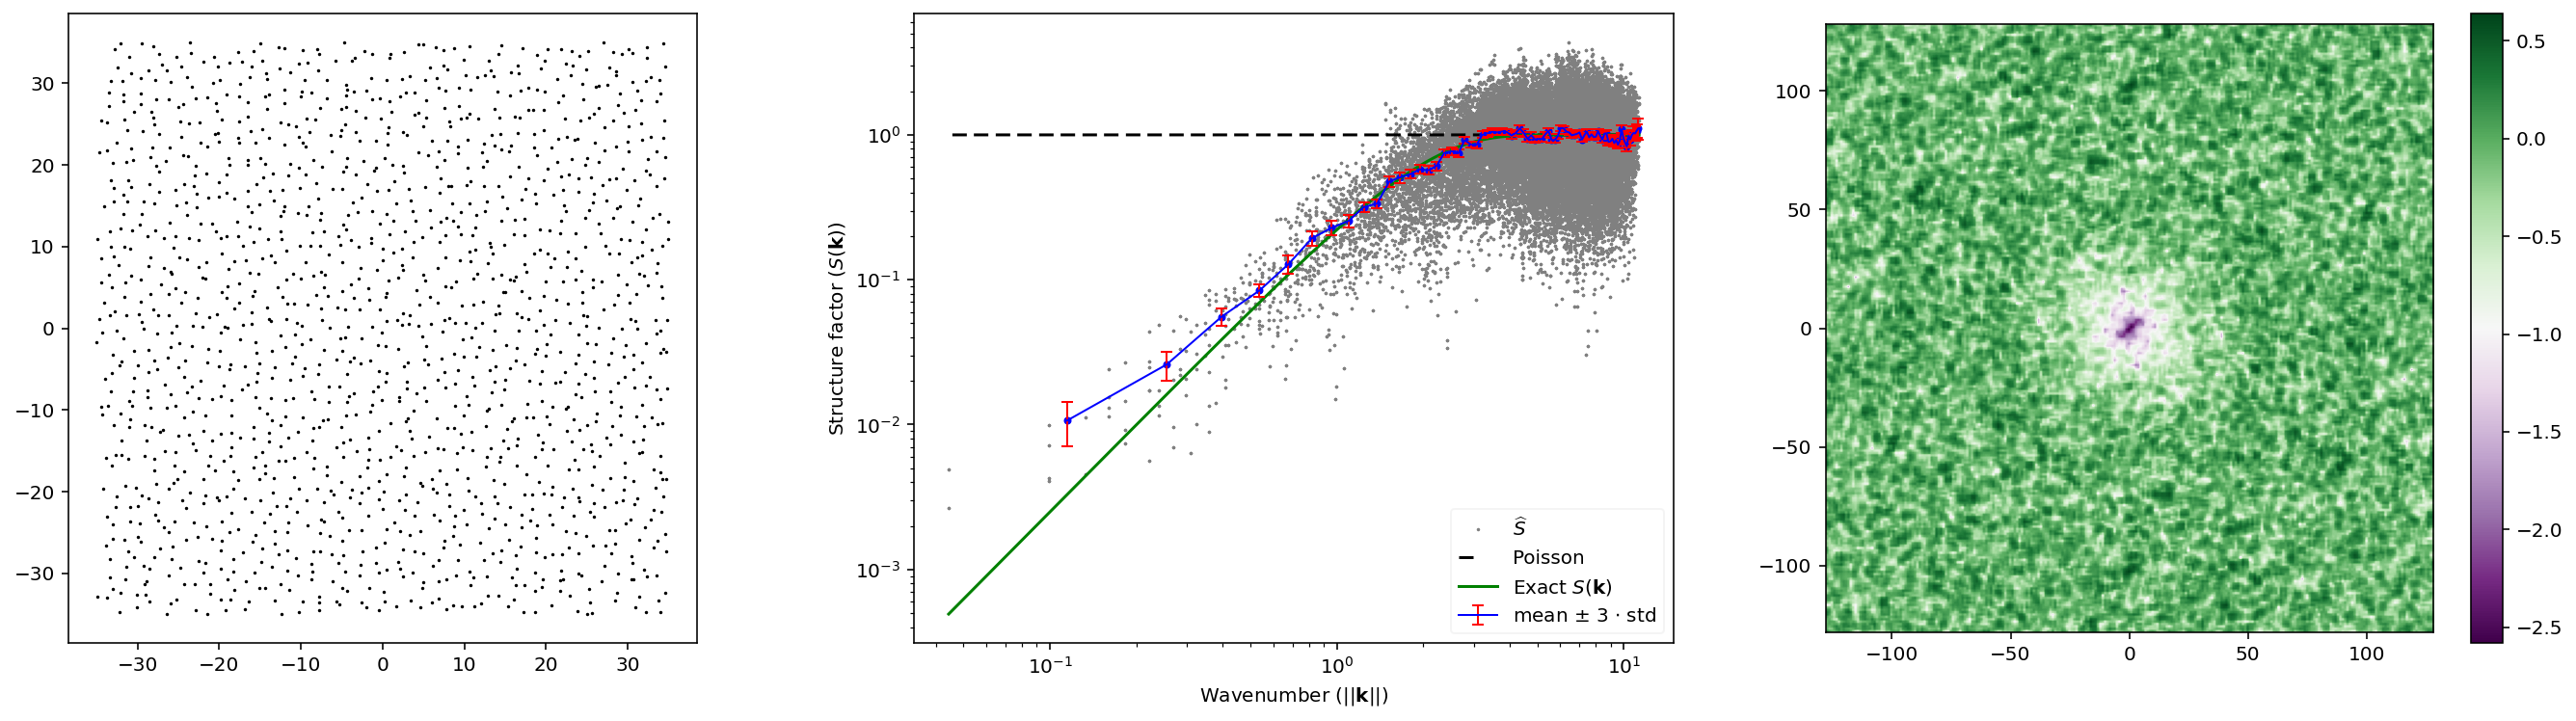

In [18]:
# Directly debiased multitapered estimator
from structure_factor.tapers import SineTaper
 
# Wavevectors
k_max = 8 # Threshold on the maximum wavenumber
x = np.linspace(-k_max, k_max, 16**2)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k = np.column_stack((X.ravel(), Y.ravel()))

# First 4 tapers of the family of sinusoidal tapers
from structure_factor.tapers import multi_sinetaper_grid
tapers = multi_sinetaper_grid(d=2, p_component_max=2)

# Scaled multitapered periodogram
k, s_ddmt = sf.tapered_estimator(k, tapers=tapers, debiased=True, direct=True)

# Plot
sf.plot_non_isotropic_estimator(k, s_ddmt, 
                                plot_type="all", # Plot type
                                exact_sf=exact_sf, # Exact structure factor 
                                error_bar=True, bins=80, # Regularization of the result
                                scale="log", # Scale
                                rasterized=True, # Rasterized the approximation points
                                label=r"$\widehat{S}$")

<AxesSubplot:>

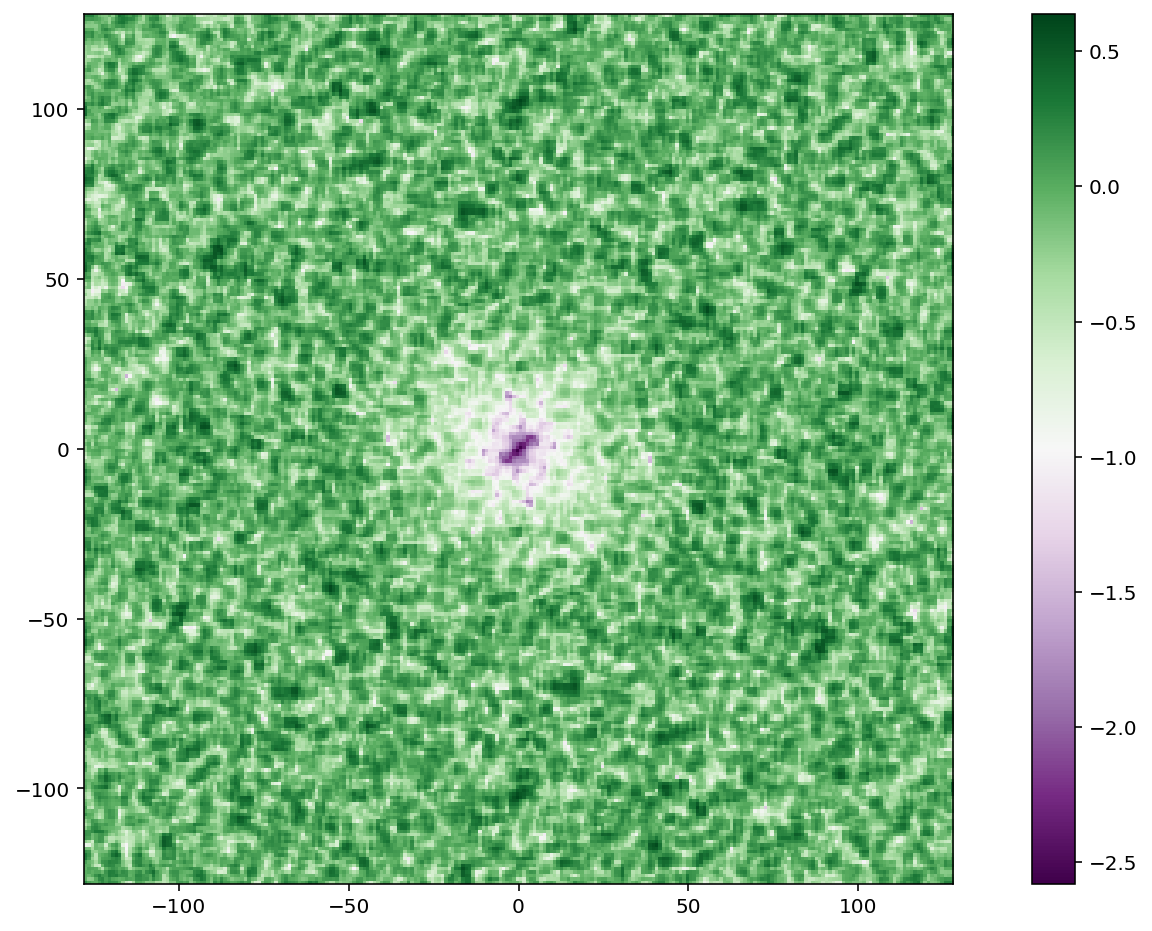

In [19]:
# Undirectly debiased multitapered estimator
from structure_factor.tapers import SineTaper
 
# Wavevectors
k_max = 8 # Threshold on the maximum wavenumber
x = np.linspace(-k_max, k_max, 16**2)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k = np.column_stack((X.ravel(), Y.ravel()))

# First 4 tapers of the family of sinusoidal tapers
from structure_factor.tapers import multi_sinetaper_grid
tapers = multi_sinetaper_grid(d=2, p_component_max=2)

# Scaled multitapered periodogram
k, s_udmt = sf.tapered_estimator(k, tapers=tapers, debiased=True, direct=False)

# Plot
sf.plot_non_isotropic_estimator(k, s_ddmt, 
                                plot_type="imshow", # Plot type
                                exact_sf=exact_sf, # Exact structure factor 
                                error_bar=True, bins=80, # Regularization of the result
                                scale="log", # Scale
                                rasterized=True, # Rasterized the approximation points
                                label=r"$\widehat{S}$")

## 3.2- Estimators assuming stationarity and isotropy


The estimators that assume the stationarity and isotropy of the point process, apply to ``PointPattern`` having ``BallWindow``.
As ``point_pattern_ball`` has a ``BallWindow`` we will be using it directly. 
In the other case, it's recommended to use a restriction.

In [20]:
sf_isotropic = StructureFactor(point_pattern_ball)

### 3.2.1- Bartlett's isotropic estimator

Bartlett's isotropic estimator $\widehat{S}_{\mathrm{BI}}$ is an estimator of the structure factor $S$ of a stationary isotropic point process. 
It is a particular case from isotropic tapered estimators using Bartlett's taper, in other words, it's the isotropic version of the scattering intensity. 
It can be evaluated on arbitrary wavenumbers or the allowed wavenumbers (reduce biased).
The complexity of this estimator is quadratic in the number of points of the ``PointPattern``.
When dealing with a large number of points, it is recommended to start with a restricted version of the ``PointPattern``, before using the large sample and increasing the window radius respectively.

/Users/dhawat/github/structure-factor/src/structure_factor/structure_factor.py:261: UserWarning: The computation may take some time for a big number of points in the PointPattern. The complexity is quadratic in the number of points. Start by restricting the PointPattern to a smaller window using  PointPattern.restrict_to_window, then increasing the window progressively.
  warnings.warn(


--- 159.46191096305847 seconds ---


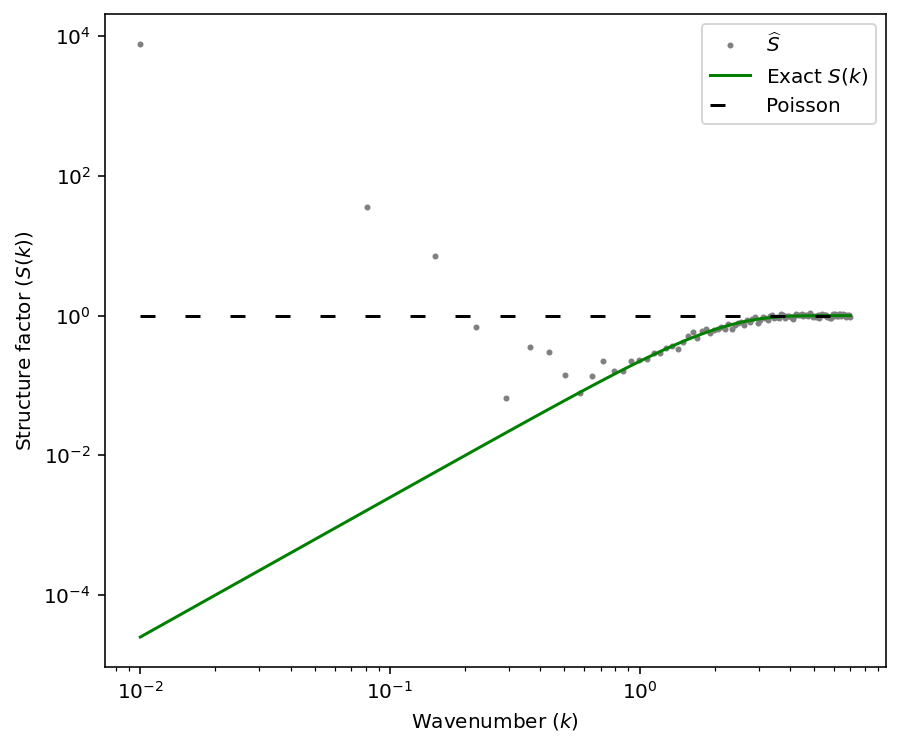

<AxesSubplot:xlabel='Wavenumber ($k$)', ylabel='Structure factor ($S(k)$)'>

In [22]:
# Bartlett's isotropic estimator on arbitrary wavenumbers
# Running time = 156 s
import time
start_time = time.time()
k_norm = np.linspace(0.01, 7, 100)
k_norm, s_bi = sf_isotropic.bartlett_isotropic_estimator(k_norm=k_norm)
print("--- %s seconds ---" % (time.time() - start_time))

#Plot
fig, axis = plt.subplots(figsize=(7,6))
sf_isotropic.plot_isotropic_estimator(k_norm, s_bi, 
                                         axis=axis,
                                         exact_sf=exact_sf, 
                                         label=r"$\widehat{S}$")

We can see the relevant bias for small wavenumbers

/Users/dhawat/github/structure-factor/src/structure_factor/structure_factor.py:261: UserWarning: The computation may take some time for a big number of points in the PointPattern. The complexity is quadratic in the number of points. Start by restricting the PointPattern to a smaller window using  PointPattern.restrict_to_window, then increasing the window progressively.
  warnings.warn(


--- 91.21881198883057 seconds ---


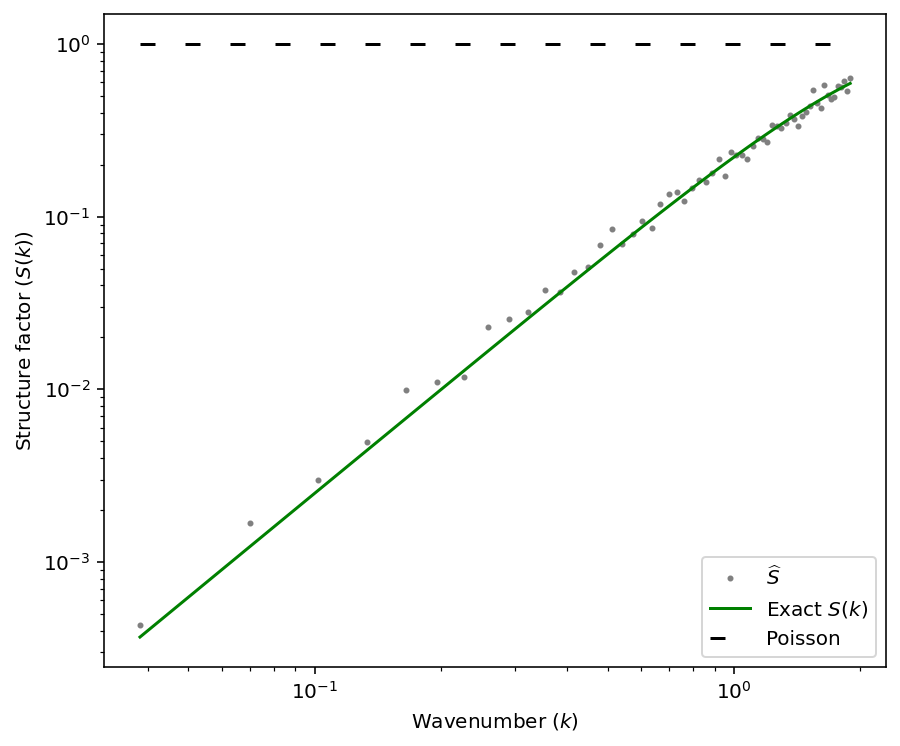

<AxesSubplot:xlabel='Wavenumber ($k$)', ylabel='Structure factor ($S(k)$)'>

In [24]:
# Bartlett's isotropic estimator on allowed wavenumbers
# Running time = 156 s
import time

start_time = time.time()
k_norm_allowed, s_bi_k_norm_allowed = sf_isotropic.bartlett_isotropic_estimator(nb_values=60)
print("--- %s seconds ---" % (time.time() - start_time))

#Plot
fig, axis = plt.subplots(figsize=(7,6))
sf_isotropic.plot_isotropic_estimator(k_norm_allowed, s_bi_k_norm_allowed, 
                                         axis=axis,
                                         exact_sf=exact_sf, 
                                         label=r"$\widehat{S}$")

This estimator seems to give the best results among all the estimators but, it's time-consuming.

### 3.2.2- Quadrature estimator isotropic

The last two isotropic estimators are based on, first estimating the pair correlation function $g$ of the ``PointPattern``,
then interpolating/extrapolating the obtained results, and finally using Ogata/Baddour&Chouinard quadrature to estimate the Hankel transform of a function of g, corresponding to the structure factor.

Let's start by estimating the pair correlation function.

#### 3.2.2.1 - Pair correlation function

**Warning: This section require the R program language https://www.rstudio.com/ to be available on your local machine.**

The toolbox contains two estimators of the pair correlation function (pcf) of a ``PointPattern``.
These two methods are ``pcf.ppp`` and ``pcf.fv`` inherited from the R package ``spatstat`` https://spatstat.org/ .

Approximating the pair correlation function using pcf.ppp

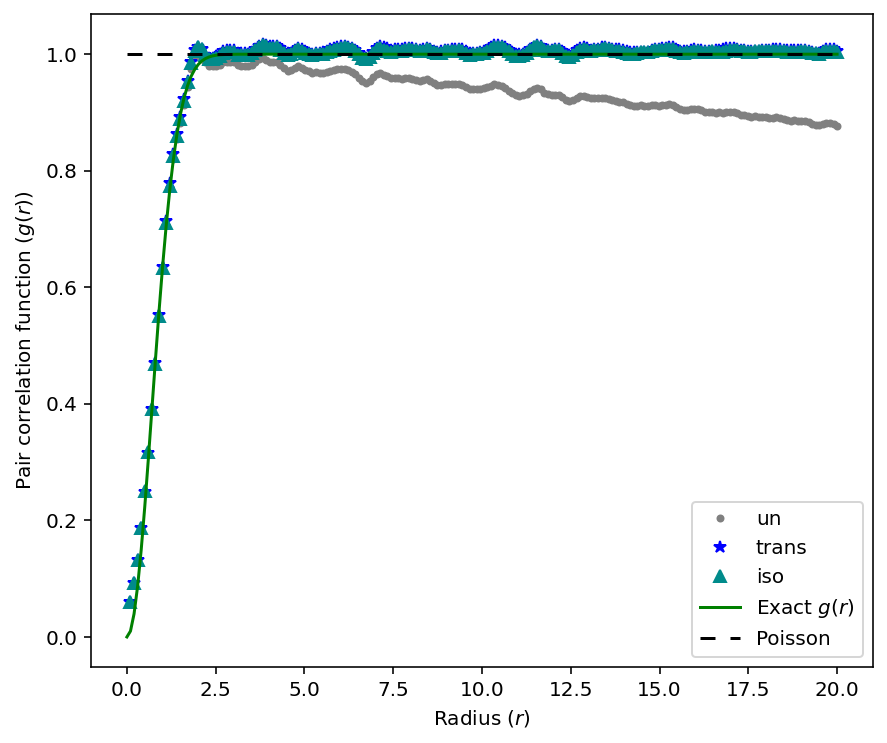

<AxesSubplot:xlabel='Radius ($r$)', ylabel='Pair correlation function ($g(r)$)'>

In [26]:
# pcf.ppp
import structure_factor.pair_correlation_function as pcf

r= np.linspace(0, 20, 200)
pcf_ppp = pcf.estimate(point_pattern_ball, # PointPattern
                        method="ppp", # Estimation method (could be "ppp" or "fv")
                        r=r, # Estimation radii 
                        correction="all" # Edge correction 
                              )

# Plot
pcf.plot(pcf_ppp, 
         exact_pcf=exact_pcf, # Exact pcf
         figsize=(7,6), # Specific figure size
         color=['grey', 'b', 'darkcyan'], # Colors of the plot
         style=[".", "*", "^"], # Marker style 
        )

Approximating the pair correlation function using pcf.fv

R[write to console]: number of data points exceeds 3000 - computing border correction estimate only



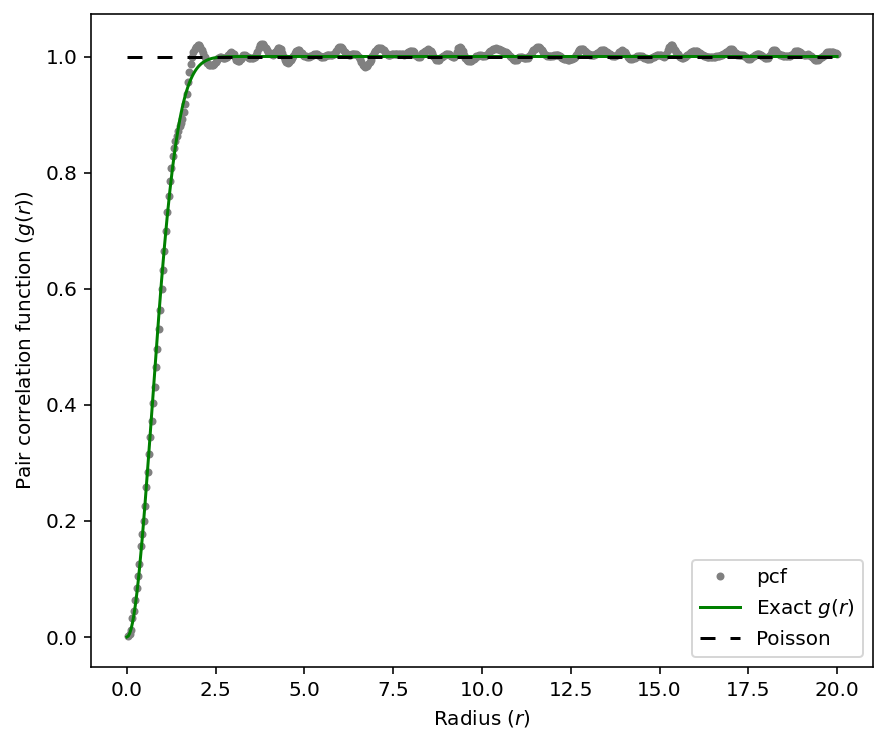

<AxesSubplot:xlabel='Radius ($r$)', ylabel='Pair correlation function ($g(r)$)'>

In [27]:
# pcf.fv
import structure_factor.pair_correlation_function as pcf

pcf_fv = pcf.estimate(point_pattern_ball, # PointPattern 
                      method="fv", # Estimation method (could be "ppp" or "fv")
                      Kest=dict(rmax=20), # Maximal estimation radius 
                      fv=dict(method="b", spar=0.2) # Correction method and sparsity
                             )

# Plot
pcf.plot(pcf_fv, 
         exact_pcf=exact_pcf, # Exact pcf
         figsize=(7,6), # Figure size
         color=['grey'], # Color
         style=["."] # Marker style
        )

After Approximating the pair correlation function the second step is to clean, interpolate, and extrapolate the result.
We will be working with the approximation result of the method ``pcf.fv``.

In [ ]:
pcf_fv

Interpolation

In [ ]:
r = pcf_fv["r"]
pcf_r = pcf_fv["pcf"]

# Interpolation
pcf_fct = pcf.interpolate(r=r, # Radii 
                          pcf_r=pcf_r, # Approximated pcf
                          drop=True, # Drop outliers (nan, neginf, and posinf)
                          extrapolate_with_one=True # Extrapolate with 1 after max(r)
                                 )


# Plot
x = np.linspace(0, 100, 200)
plt.plot(x, pcf_fct(x), 'b.', label="Approximated pcf") 
plt.plot(x, exact_pcf(x), 'g', label="Exact pcf")
plt.legend()
plt.show()

#### 3.2.2.2- Estimate the structure factor using Ogata quadrature

In [ ]:
# Ogata quadrature 
k_norm = np.linspace(0.5, 30, 1000) # Wavenumbers
k_norm, s_ho = sf_isotropic.quadrature_estimator_isotropic(pcf_fct, # Estimated pcf function
                                                 k_norm=k_norm, # wavenumbers
                                                 method="Ogata", # Quadrature method ("Ogata", or "BaddourChouinard")
                                                 step_size=0.01, # Step size
                                                 nb_points=1000 # Number of points
                                                )
# Plot
fig, axis = plt.subplots(figsize=(7,6))
fig = sf_isotropic.plot_isotropic_estimator(k_norm, s_ho, 
                                               axis=axis, # Plot axis
                                               error_bar=True, bins=80, # Regularize the results
                                               exact_sf=exact_sf, # Exact structure factor 
                                               label=r"$\widehat{S}$",
                                               #file_name="ginibre_s_ho.pdf" # save the figure
                                              )

#### 3.2.2.2- Estimate the structure factor using Baddour & Chouinard quadrature

In [ ]:
# Baddour & Chouinard quadrature 
k_norm = np.linspace(0.5, 30, 1000) # Wavenumbers
r_max = np.max(r) # Maximum radius for which the pcf has been approximated
k_norm, s_hbc = sf_isotropic.quadrature_estimator_isotropic(pcf_fct, # Estimated pcf function
                                                 k_norm=k_norm, # wavenumbers
                                                 method="BaddourChouinard", # Quadrature method ("Ogata", or "BaddourChouinard")
                                                 r_max=r_max, # Step size
                                                 nb_points=1000 # Number of points
                                                )
# Plot
fig, axis = plt.subplots(figsize=(7,6))
fig = sf_isotropic.plot_isotropic_estimator(k_norm, s_hbc, 
                                            axis=axis, # Plot axis
                                            exact_sf=exact_sf, # Exact structure factor 
                                            label=r"$\widehat{S}$",
                                            #file_name="ginibre_s_hbc.pdf" # save the figure
                                              )

# 3.4- Hyperuniformity

Our strategy for studying the hyperuniformity of a point process is by, first studying the index $H$ of hyperuniformity of the ``PointPattern``.
If $H< 10^{-3}$ then the point process is effectively hyperuniform and so maybe hyperuniform. 
In this case, we study the power decay to zero of the structure factor $\alpha$ which indicates the possible class of hyperuniformity.
If the $H$ rejects the hypothesis of hyperuniformity then we conclude that the point process is not hyperuniform.

In what follows, we will be using the results of Bartlett's isotropic estimator for studying the 
effective hyperuniformity and the hyperuniformity class of the Ginibre point pattern.
We know that the Ginibre ensemble is a first-class hyperuniform point process with power decay $\alpha_{Ginibre} = 2$.


In [ ]:
# Initialize ``Hyperuniformity``
from structure_factor.hyperuniformity import Hyperuniformity

hyperuniformity_test = Hyperuniformity(k_norm_allowed, s_bi_k_norm_allowed)

### 1.3.1- Effective hyperuniformity

In [ ]:
# Effective hyperuniformity
H_ginibre, _ = hyperuniformity_test.effective_hyperuniformity(k_norm_stop=0.2) # H index

# Visualization of the results
import matplotlib.pyplot as plt
import structure_factor.utils as utils
fitted_line = hyperuniformity_test.fitted_line # Fitted line to s_bi
x = np.linspace(0, 2, 300)
fig, axis =plt.subplots(figsize=(7,5))
axis.plot(k_norm_allowed, s_bi_k_norm_allowed, 'b', marker=".", label="Approximated structure factor")
axis.plot(x, fitted_line(x), 'r--', label= "Fitted line")
axis.plot(k_norm_allowed, GinibrePointProcess.structure_factor(k_norm_allowed), 'g', label=r"$S(k)$")
axis.annotate('H={}'.format(H_ginibre), xy=(0, 0), xytext=(0.01,0.3),
            arrowprops=dict(facecolor='black', shrink=0.01))
axis.legend()
axis.set_xlabel('wavelength (k)')
axis.set_ylabel(r"Structure factor ($\mathsf{S}(k)$")
plt.show()

As $H<10^{-3}$ then we conclude that the Ginibre ensemble is effectively hyperuniformity.

### 1.3.2- Hyperuniformity class

In [ ]:
# Hyperuniformity class
alpha_ginibre, _ = hyperuniformity_test.hyperuniformity_class(k_norm_stop=0.4)

# Visualization of the results
import matplotlib.pyplot as plt
import structure_factor.utils as utils
fitted_poly = hyperuniformity_test.fitted_poly # Fitted polynomial to s_bi
fig, axis =plt.subplots(figsize=(7,5))
axis.plot(k_norm_allowed, s_bi_k_norm_allowed, 'b', marker=".", label="Approximated structure factor")
axis.plot(k_norm_allowed, GinibrePointProcess.structure_factor(k_norm_allowed), 'g', label=r"$S(k)$")
axis.plot(k_norm_allowed, fitted_poly(k_norm_allowed), 'r--', label= "Fitted line")
axis.annotate(r" $\alpha$ ={}".format(alpha_ginibre), xy=(0, 0), xytext=(0.01,0.4),
            arrowprops=dict(facecolor='black', shrink=0.1))
axis.legend()
axis.set_xlabel('wavelength (k)')
axis.set_ylabel(r"Structure factor ($\mathsf{S}(k)$")
plt.show()

This power decay found by this test is $\alpha \approx 1.99$ which is a good approximation of the exact value $\alpha_{Ginibre}=2$.
Thus this test successfully predicts the hyperuniformity class of the Ginibre Ensemble.